In [24]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:


file_name = 'Figure_5_data.csv'
df = pd.read_csv(file_name)  # Directly use the file name


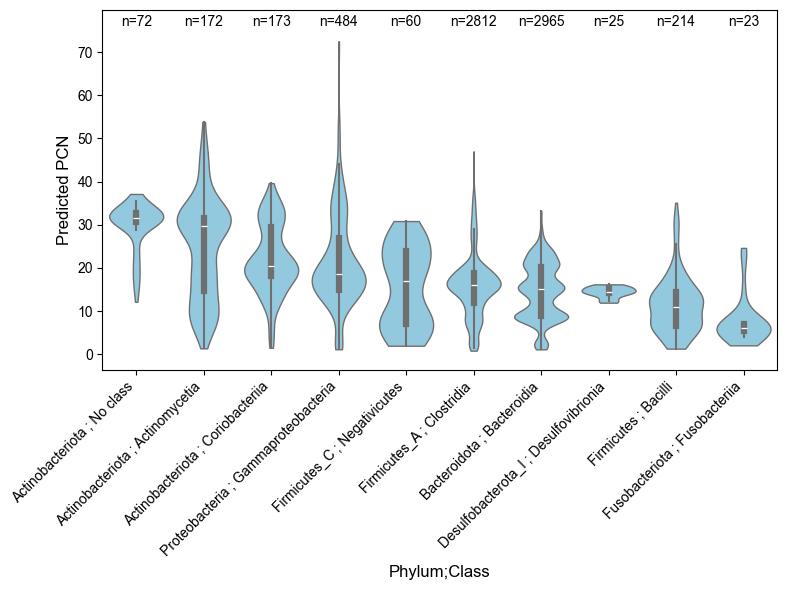

In [ ]:

df_filtered = df[df['host_taxonomy'].notnull()].copy()

def extract_taxonomy(tax_str):
    parts = tax_str.split(';')
    phylum, class_ = None, None
    for part in parts:
        if part.startswith('p__'): phylum = part.replace('p__', '')
        elif part.startswith('c__'): class_ = part.replace('c__', '')
    return phylum, class_

df_filtered[['phylum', 'class']] = df_filtered['host_taxonomy'].apply(
    lambda x: pd.Series(extract_taxonomy(x)))
df_filtered['class'] = df_filtered['class'].fillna('No class')

# Get Human-associated data
human_data = df_filtered[df_filtered['ecosystem_group'] == 'Human_associated'].copy()
human_data['phylum_class'] = human_data['phylum'] + " / " + human_data['class']

# Replace '/' with ';' in the phylum_class column for x-axis labels
human_data['phylum_class'] = human_data['phylum_class'].str.replace('/', ';')

# Calculate statistics
group_stats = human_data.groupby('phylum_class').agg(
    count=('PCN', 'size'),
    median_pcn=('PCN', 'median')
).reset_index()

# Filter and sort
filtered_stats = group_stats[group_stats['count'] > 1]
top_phylum_class = filtered_stats.sort_values('median_pcn', ascending=False).head(10)['phylum_class']

# Prepare final dataset
human_data_top = human_data[human_data['phylum_class'].isin(top_phylum_class)].copy()
human_data_top['phylum_class'] = pd.Categorical(
    human_data_top['phylum_class'],
    categories=top_phylum_class,
    ordered=True
)

# Create plot with adjusted y-axis
plt.figure(figsize=(8, 6))

# Calculate y-axis padding
y_padding = human_data_top['PCN'].max() * 0.05  # 5% padding


violin = sns.violinplot(
    data=human_data_top,
    x='phylum_class',
    y='PCN',
    color='skyblue',
    inner='box',
    linewidth=1,
    density_norm='width',
    order=top_phylum_class,
    cut=0 
)

# Add count annotations
with pd.option_context('mode.chained_assignment', None):
    counts = human_data_top.groupby('phylum_class', observed=True).size()

for i, phylum_class in enumerate(top_phylum_class):
    violin.text(i, human_data_top['PCN'].max() * 1.05, 
             f'n={counts[phylum_class]}', 
             ha='center', 
             fontsize=10)

# Customize plot
plt.xlabel('Phylum;Class', fontsize=12)
plt.ylabel('Predicted PCN', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Set y-axis limits with negative padding to prevent violins from touching axis
plt.ylim(bottom=-y_padding, top=human_data_top['PCN'].max() * 1.1)

# Save outputs
output_filename = 'fig_5C'
plt.savefig(f'{output_filename}.pdf', dpi=1200, format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()
